In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import time

Image shape: (224, 225, 3)


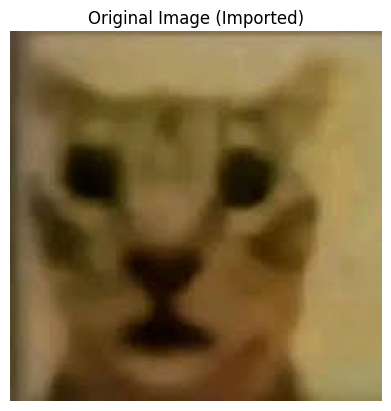

In [4]:
img = plt.imread("/content/drive/MyDrive/pictures/meo.jpeg")
if img.dtype == np.uint8:
    img = img.astype(np.float32) / 255.0

h, w, c = img.shape
print("Image shape:", img.shape)

plt.imshow(img)
plt.title("Original Image (Imported)")
plt.axis("off")
plt.show()

In [5]:
h, w, c = img.shape
pixels = img.reshape(-1, 3)
pixelCount = pixels.shape[0]

print("Pixel count:", pixelCount)
print("Pixels shape:", pixels.shape)
print(pixels[:5])

Pixel count: 50400
Pixels shape: (50400, 3)
[[0.3254902  0.27058825 0.22745098]
 [0.3254902  0.27058825 0.22745098]
 [0.33333334 0.27058825 0.21960784]
 [0.34117648 0.2784314  0.22745098]
 [0.3529412  0.2901961  0.23137255]]


CPU grayscale time: 0.2050 seconds


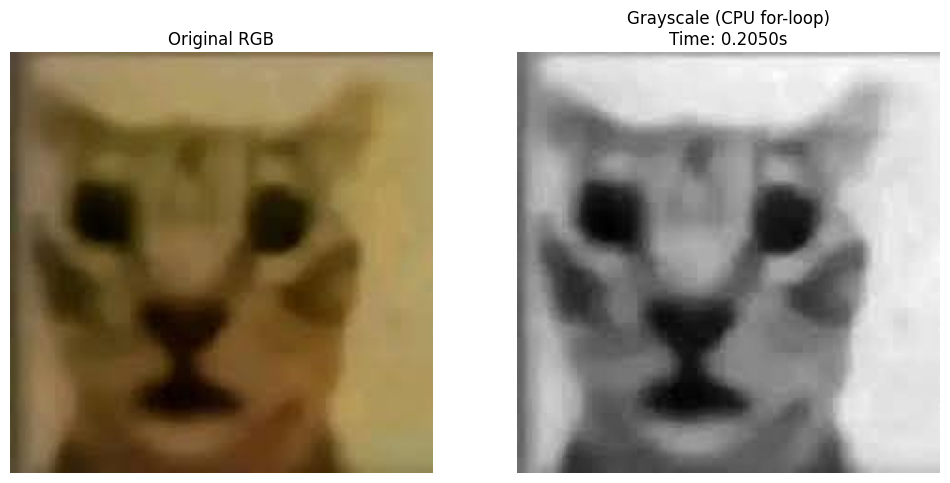

In [6]:
t0 = time.time()

gray = np.zeros(pixelCount, dtype=np.float32)
for i in range(pixelCount):
    r, g, b = pixels[i]
    # gray[i] = 0.299 * r + 0.587 * g + 0.114 * b
    gray[i] = (r + g + b) / 3

cpu_time = time.time() - t0
print(f"CPU grayscale time: {cpu_time:.4f} seconds")

gray_img = gray.reshape(h, w)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))

ax1.imshow(img)
ax1.set_title("Original RGB")
ax1.axis("off")

ax2.imshow(gray_img, cmap="gray")
ax2.set_title(f"Grayscale (CPU for-loop)\nTime: {cpu_time:.4f}s")
ax2.axis("off")

plt.show()


GPU grayscale time: 1.6779 seconds


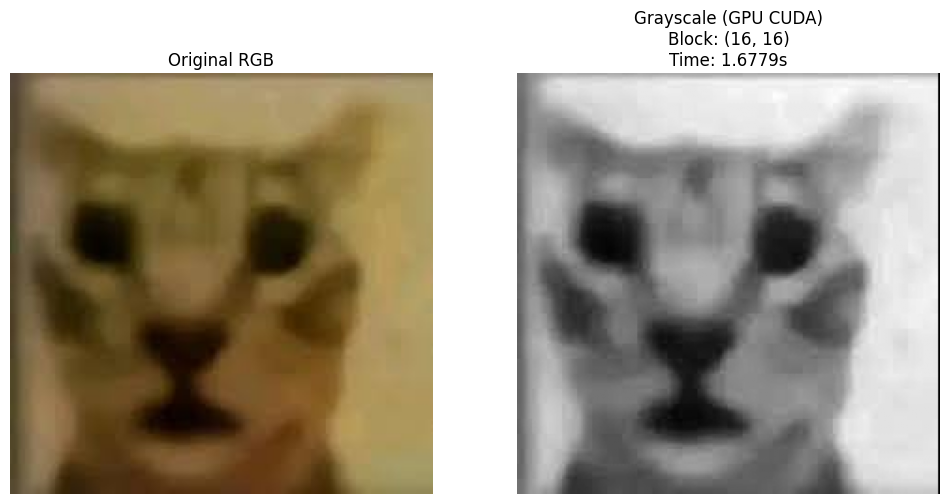

In [7]:
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1

t0 = time.time()

@cuda.jit
def rgb2gray_kernel(rgb, gray, width, height):
    x, y = cuda.grid(2)
    if x < height and y < width:
        i = x * width + y
        r = rgb[i, 0]
        g = rgb[i, 1]
        b = rgb[i, 2]
        gray[i] = (r + g + b) / 3


d_rgb = cuda.to_device(pixels.astype(np.float32))
d_gray = cuda.device_array(pixelCount, dtype=np.float32)

threads_per_block = (16, 16)
blocks_per_grid_x = (w + threads_per_block[0] - 1) // threads_per_block[0]
blocks_per_grid_y = (h + threads_per_block[1] - 1) // threads_per_block[1]
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

rgb2gray_kernel[blocks_per_grid, threads_per_block](d_rgb, d_gray, w, h)
cuda.synchronize()

gray_gpu = d_gray.copy_to_host()
gray_img_gpu = gray_gpu.reshape(h, w)

gpu_time = time.time() - t0
print(f"GPU grayscale time: {gpu_time:.4f} seconds")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.imshow(img)
ax1.set_title("Original RGB")
ax1.axis("off")

ax2.imshow(gray_img_gpu, cmap="gray")
ax2.set_title(f"Grayscale (GPU CUDA)\nBlock: {threads_per_block}\nTime: {gpu_time:.4f}s")
ax2.axis("off")

plt.show()